In [1]:
import pandas as pd
import numpy as np
from brian2 import *
from brian2modelfitting import *

WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
 [py.warnings]
WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)
 [py.warnings]


In [2]:
# Load Input and Output Data
df_inp_traces = pd.read_csv('input_traces_hh.csv')
df_out_traces = pd.read_csv('output_traces_hh.csv')

inp_traces = df_inp_traces.to_numpy()
inp_traces = inp_traces[:, 1:]

out_traces = df_out_traces.to_numpy()
out_traces = out_traces[:, 1:]

In [3]:
# Model Fitting
## Parameters
area = 20000*umetre**2
El = -65*mV
EK = -90*mV
ENa = 50*mV
VT = -63*mV
dt = 0.01*ms
defaultclock.dt = dt

In [4]:
## Modle Definition
eqs='''
dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I)/Cm : volt
dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
    (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
    (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
    (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
g_na : siemens (constant)
g_kd : siemens (constant)
gl   : siemens (constant)
Cm   : farad (constant)
'''

In [5]:
class CustomMetric(TraceMetric):
    def get_features(self, traces, output, n_traces, dt):
        mselist = []
        output = atleast_2d(output)

        for i in arange(n_traces):
            temp_out = np.diff(output[i])
            temp_traces = traces[i::n_traces]

            for trace in temp_traces:
                trace = np.diff(trace)
                
                mse = sum(square(temp_out - trace))
                mselist.append(mse)

        feat_arr = reshape(array(mselist), (n_traces,
                           int(len(mselist)/n_traces)))

        return feat_arr

    def get_errors(self, features):
        errors = features.mean(axis=0)
        return errors

In [6]:
class CustomMetric2(MSEMetric):
    def get_features(self, traces, output, n_traces, dt):
        mselist = []
        output = atleast_2d(output)

        for i in arange(n_traces):
            temp_out = np.diff(output[i])
            temp_traces = traces[i::n_traces]

            for trace in temp_traces:
                trace = np.diff(trace)
                
                mse = sum(square(temp_out - trace))
                mselist.append(mse)

        feat_arr = reshape(array(mselist), (n_traces,
                           int(len(mselist)/n_traces)))

        return feat_arr


In [7]:
## Optimization and Metric Choice
n_opt = NevergradOptimizer()
# metric = CustomMetric()
metric = CustomMetric2()

metric

In [8]:
## Fitting
fitter = TraceFitter(model=eqs, input_var='I', output_var='v',
                     input=inp_traces*amp, output=out_traces*mV, dt=dt,
                     n_samples=20,
                     param_init={'v': 'VT'},
                     method='exponential_euler',)

exponential_euler


In [9]:
res, error = fitter.fit(n_rounds=4,
                        optimizer=n_opt, metric=metric,
                        callback='text',
                        gl = [1e-09 *siemens, 1e-07 *siemens],
                        g_na = [2e-06*siemens, 2e-04*siemens],
                        g_kd = [6e-07*siemens, 6e-05*siemens],
                        Cm=[0.1*ufarad*cm**-2 * area, 2*ufarad*cm**-2 * area])

Round 0: fit (7.473239712399528e-08, 1.7198514196744937e-05, 2.054134262359811e-10, 6.701832933825476e-05) with error: 0.004297265803247801
Round 1: fit (8.165498901969242e-08, 1.5427934109614596e-05, 2.0045452311434988e-10, 4.84687561993012e-05) with error: 0.00379979829634272
Round 2: fit (8.165498901969242e-08, 1.5427934109614596e-05, 2.0045452311434988e-10, 4.84687561993012e-05) with error: 0.00379979829634272
Round 3: fit (8.631286342031492e-08, 1.7220961933122154e-05, 1.993449394393278e-10, 4.259552594060275e-05) with error: 0.0035320978099293277


In [10]:
## Show results
all_output = fitter.results(format='dataframe')
print(all_output)

              gl      g_kd            Cm      g_na    errors
0   4.957020e-08  0.000019  1.173356e-10  0.000055  0.006122
1   8.468311e-08  0.000028  2.999267e-10  0.000086  0.004878
2   7.406813e-08  0.000018  2.739524e-10  0.000036  0.004545
3   3.971004e-08  0.000027  1.062369e-10  0.000163  0.007297
4   5.958834e-08  0.000023  1.735706e-10  0.000087  0.005904
5   6.307087e-08  0.000039  3.263986e-10  0.000048  0.004880
6   3.416776e-08  0.000040  3.079525e-10  0.000055  0.004729
7   7.092687e-08  0.000017  1.812430e-10  0.000047  0.004949
8   3.580662e-08  0.000042  1.269593e-10  0.000046  0.006213
9   7.473240e-08  0.000017  2.054134e-10  0.000067  0.004297
10  5.697483e-08  0.000012  1.857391e-10  0.000171  0.006012
11  5.598205e-08  0.000051  1.197820e-10  0.000059  0.006398
12  7.606240e-08  0.000030  2.817713e-10  0.000107  0.004557
13  1.501280e-08  0.000035  1.159351e-10  0.000053  0.006524
14  8.512294e-08  0.000030  3.368505e-10  0.000147  0.005132
15  3.308056e-08  0.0000

exponential_euler


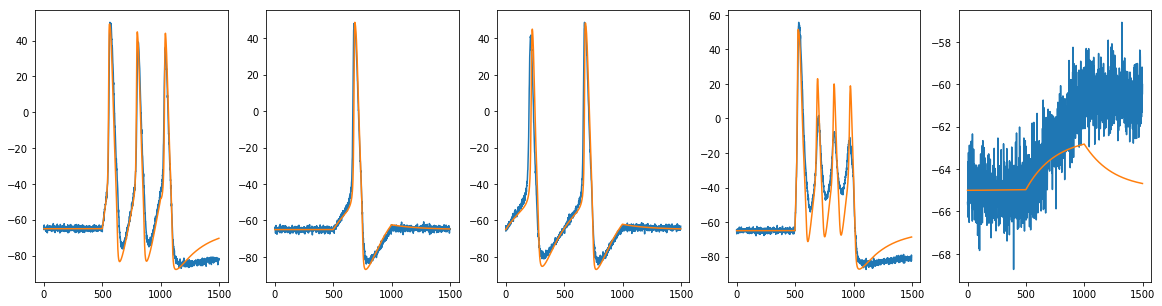

In [11]:
## Visualization of the results
start_scope()
fits = fitter.generate_traces(params=None, param_init={'v': -65*mV})

fig, ax = plt.subplots(ncols=5, figsize=(20,5))
ax[0].plot(out_traces[0].transpose())
ax[0].plot(fits[0].transpose()/mV)

ax[1].plot(out_traces[1].transpose())
ax[1].plot(fits[1].transpose()/mV)
ax[2].plot(out_traces[2].transpose())
ax[2].plot(fits[2].transpose()/mV)
ax[3].plot(out_traces[3].transpose())
ax[3].plot(fits[3].transpose()/mV)
ax[4].plot(out_traces[4].transpose())
ax[4].plot(fits[4].transpose()/mV)
plt.show()